In [15]:
from datasets import load_dataset, DatasetDict
from datasets import ClassLabel
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, get_linear_schedule_with_warmup
from torch.optim import AdamW as TorchAdamW
from transformers import AutoTokenizer
import numpy as np
import evaluate
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#MODEL = "distilbert-base-uncased"
#MODEL = "google/bigbird-roberta-base"
MODEL = "bert-base-uncased"

#explicitly load dataset from local file (hugging face insists on a constant train/test split when loading from hub)
dataset = load_dataset('csv', data_files="data/coarse-labeled-urls-headers.csv")
dataset = dataset.shuffle()
dataset = dataset['train'].train_test_split(test_size=0.10)

tokenizer = AutoTokenizer.from_pretrained(MODEL)
labels = ClassLabel(names_file="data/coarse_labels.txt")
features = ['url', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']

#filter out low freq granular labels
#with open('data/high-freq-labels.txt', 'r') as file:
    #lines = file.readlines()
    #labels_to_keep = [line.strip() for line in lines]
    
# Filter the dataset based on labels
filtered_dataset = dataset.filter(lambda example: example['coarse_label'] in labels.names)

def tokenize_function(batch):
    # Combine relevant features into a single string for tokenization
    text_to_tokenize = " ".join([str(batch[feature]) for feature in features])
    tokens = tokenizer(text_to_tokenize, padding='max_length', truncation=True)
    tokens["label"] = labels.str2int(batch["coarse_label"])
    return tokens

# Tokenize the datasets
tokenized_train_dataset = filtered_dataset["train"].map(tokenize_function, batched=False)
tokenized_test_dataset = filtered_dataset["test"].map(tokenize_function, batched=False)

# Optionally, you can cast the "label" column to ClassLabel
#tokenized_train_dataset = tokenized_train_dataset.cast_column("coarse_label", labels)
#tokenized_test_dataset = tokenized_test_dataset.cast_column("coarse_label", labels)

Filter:   0%|          | 0/4004 [00:00<?, ? examples/s]

Filter:   0%|          | 0/445 [00:00<?, ? examples/s]

Map:   0%|          | 0/4004 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [77]:
    
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=8)
#training_args = TrainingArguments(output_dir="test_trainer_1.1", evaluation_strategy="epoch", max_steps=1)#, push_to_hub=True)
training_args = TrainingArguments(
    output_dir="bert_coarse_1.2-8", 
    evaluation_strategy="epoch", 
    save_strategy='epoch', 
    num_train_epochs=4,
    learning_rate=1e-5,  # Initial learning rate
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=100,  # Number of warmup steps
    weight_decay=0.0 # Weight decay coefficient)
)
    
#optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)  # Define the optimizer
optimizer = TorchAdamW(model.parameters(), lr=training_args.learning_rate)  # Define the optimizer
metric = evaluate.load("accuracy")
    
# Calculate the total number of training steps
total_steps = len(tokenized_train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=total_steps
)
    
eval_predictions = []
eval_labels = []
    
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #store the predictions and labels
    eval_predictions.extend(predictions.tolist())
    eval_labels.extend(labels.tolist())
        
    return metric.compute(predictions=predictions, references=labels)
    
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    optimizers = (optimizer, scheduler)
)
    
trainer.train()

# These will push a new model version to the Hugging Face Hub upon training completion
#trainer.push_to_hub("PDAP/url-classifier-test")
#tokenizer.push_to_hub("PDAP/url-classifier-test")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.549300,1.189919,0.602247
2,0.992100,1.059439,0.669663
3,0.763200,0.997164,0.680899
4,0.642300,1.014904,0.685393


TrainOutput(global_step=2004, training_loss=0.9857199211082535, metrics={'train_runtime': 8321.7176, 'train_samples_per_second': 1.925, 'train_steps_per_second': 0.241, 'total_flos': 4214213676761088.0, 'train_loss': 0.9857199211082535, 'epoch': 4.0})

In [7]:
# Evaluate the final model on the test dataset
evaluation_results = trainer.evaluate()

In [8]:
# Access the final accuracy from the evaluation results
final_accuracy = evaluation_results["eval_accuracy"]
print("Final Accuracy:", final_accuracy)

Final Accuracy: 0.4904153354632588


### Can I load the model and train for additional epochs

In [26]:
# Define your model and training arguments as before
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=18)
training_args = TrainingArguments(output_dir="bert_1.1", evaluation_strategy="epoch", save_strategy='epoch', num_train_epochs=1)  # Set num_train_epochs to 2 to continue training for another epoch

# Load the saved state of the model
model_path = "bert_1.1/checkpoint-437/"  # Specify the path where the model was saved
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Define your trainer as before
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics
)

# Continue training for another epoch
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.475354,0.559105


Checkpoint destination directory bert_1.1/checkpoint-437 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=437, training_loss=1.5890977802756723, metrics={'train_runtime': 12228.6065, 'train_samples_per_second': 0.286, 'train_steps_per_second': 0.036, 'total_flos': 919705242101760.0, 'train_loss': 1.5890977802756723, 'epoch': 1.0})

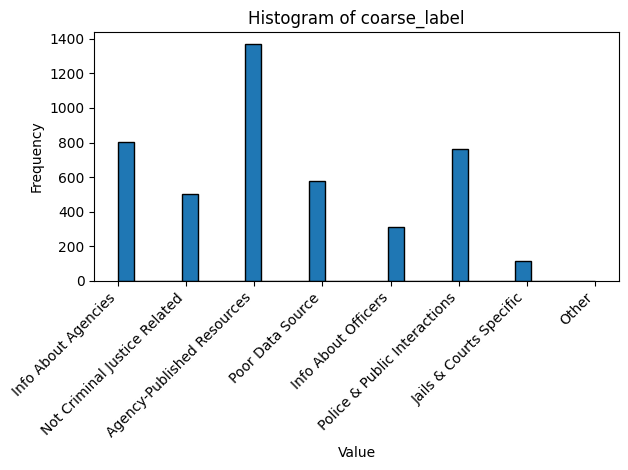

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def create_histogram(csv_file, column_name):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file)

    # Check if the column name exists in the DataFrame
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in the CSV file.")
        return

    # Create a histogram of the specified column
    plt.hist(df[column_name], bins=8, edgecolor='black', log=True)
    plt.title(f'Histogram of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Example usage
csv_file = 'data/coarse-labeled-urls-headers.csv'
column_name = 'coarse_label'
create_histogram(csv_file, column_name)

In [56]:
filtered_dataset["train"]["h2"]

['[]',
 '["Available Data"]',
 '["Find Posts By Topic", "You might also like...", "Police", "City-Wide Information", "Top Requests", "Policies"]',
 None,
 '["How  can we help?", "Recent News Articles", "\\nHow to use a HAWK signal\\n", "\\nWhitestown Town Council Announces 2024 Board Appointments\\n", "Visit Us", "Contact Us", "Stay Connected"]',
 '["Menu"]',
 None,
 '["Menu"]',
 '[]',
 '[]',
 '["Menu", "\\n  Categories > Public Safety\\n  \\n", "\\n        Sort\\n      ", "\\n    Sort by Most Relevant\\n    \\n", "\\n        Filter\\n      ", "\\nAuthority\\n\\n", "\\nCategories\\n\\n", "\\nView Types\\n\\n", "\\nTags\\n\\n", "\\nActive Calls for Northeast Division / Dallas Police Department\\nCOMMUNITY CREATED\\n", "\\nDallas Police Active Calls\\n", "\\nActive Calls for Southeast Division / Dallas Police Department\\nCOMMUNITY CREATED\\n", "\\nActive Calls in DPD North Central Division\\nCOMMUNITY CREATED\\n", "\\nActive Calls in DPD Northeast Division\\nCOMMUNITY CREATED\\n", "\\nA

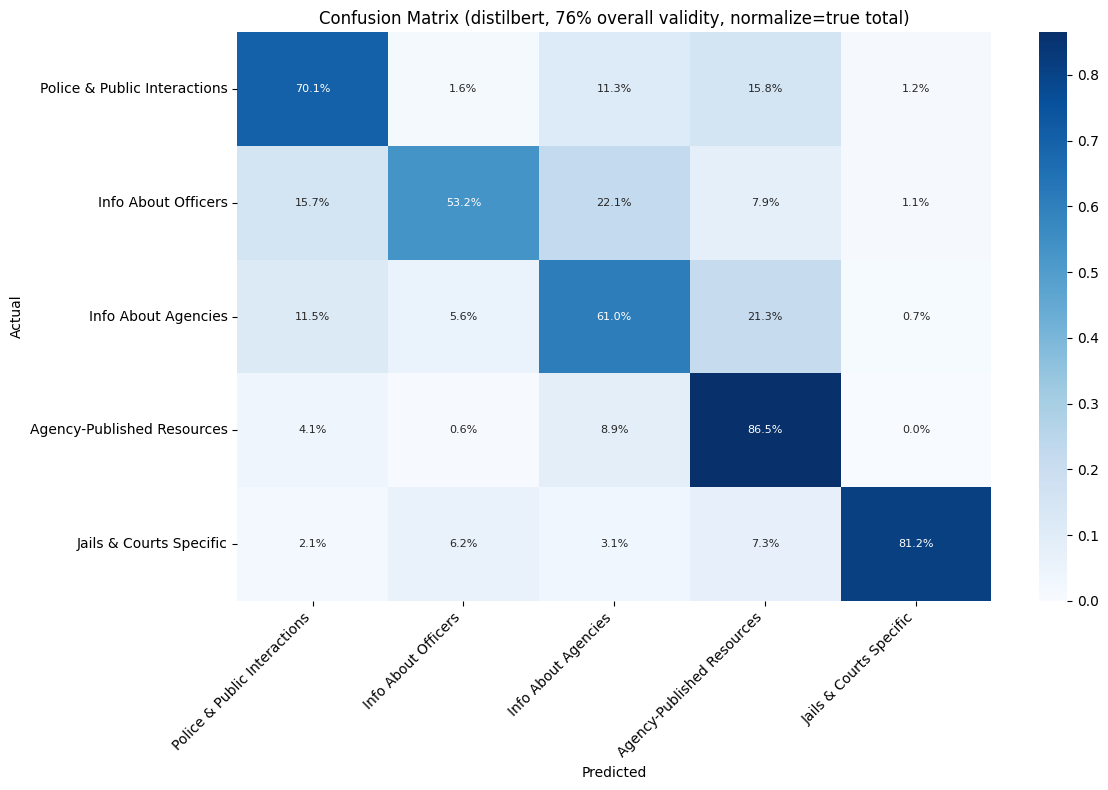

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the unique class labels
#classes = np.unique(eval_labels)
classes = [0,1,2,3,4]

# Compute confusion matrix
conf_mat = confusion_matrix(eval_labels, eval_predictions, labels=classes, normalize='true')

# Plot confusion matrix as percentages
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat, annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
#sns.heatmap(conf_mat, annot=True, fmt="", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
plt.title('Confusion Matrix (distilbert, 76% overall validity, normalize=true total)')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Actual')
plt.tight_layout()
#plt.savefig("confusion-matrix-distilbert-1_1.png", dpi=500)
plt.savefig("cm_73p_norm-true.png", dpi=500)
plt.show()

In [71]:
confusion_matrix(eval_labels, eval_predictions, labels=classes)

array([[471,  11,  76, 106,   8],
       [ 44, 149,  62,  22,   3],
       [ 68,  33, 361, 126,   4],
       [ 44,   6,  95, 927,   0],
       [  2,   6,   3,   7,  78]])

/var/folders/zh/qjtgnxgd20g5nv9j7bmktmcm0000gn/T/ipykernel_17955/3618998389.py:9: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(conf_mat/conf_mat.sum(axis=0), annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})


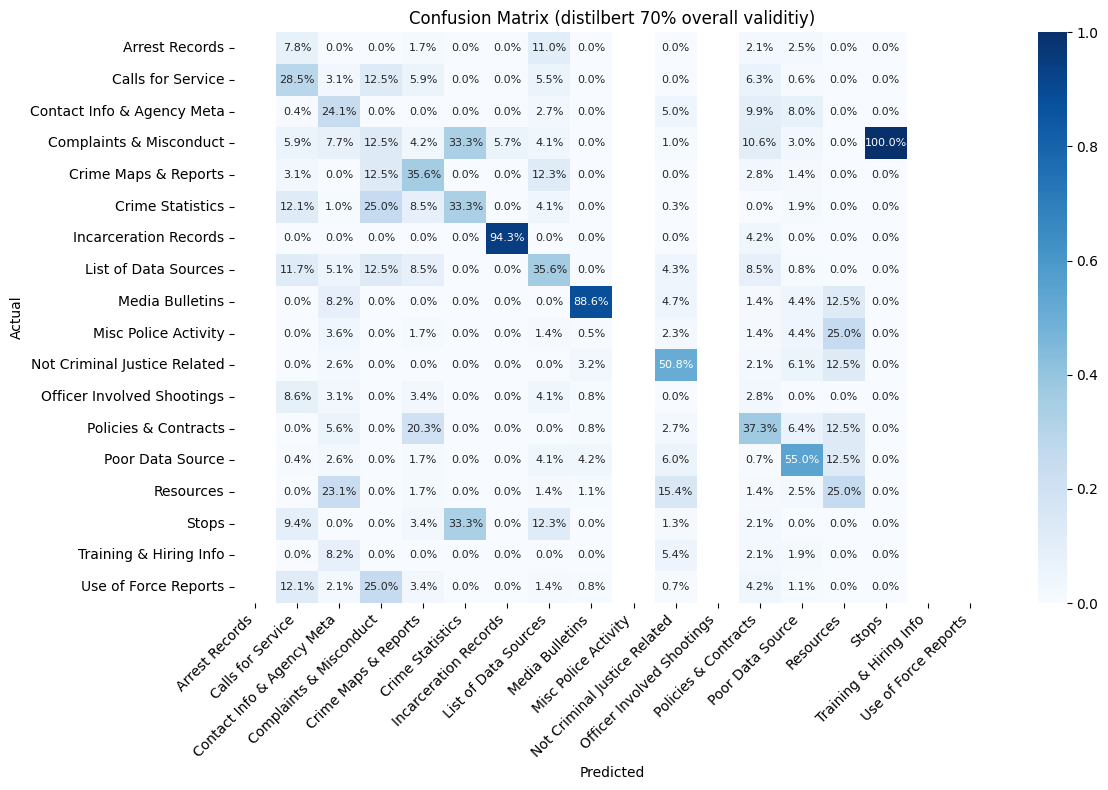

In [27]:
# Get the unique class labels
classes = np.unique(eval_labels)

# Compute confusion matrix
conf_mat = confusion_matrix(eval_labels, eval_predictions, labels=classes)

# Plot confusion matrix as percentages
plt.figure(figsize=(12, 8))
sns.heatmap(conf_mat/conf_mat.sum(axis=0), annot=True, fmt=".1%", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
#sns.heatmap(conf_mat, annot=True, fmt="", cmap="Blues", xticklabels = labels.names, yticklabels = labels.names, annot_kws={"size": 8})
plt.title('Confusion Matrix (distilbert 70% overall validitiy)')
plt.xlabel('Predicted')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Actual')
plt.tight_layout()
#plt.savefig("confusion-matrix-distilbert-1_1.png", dpi=500)
plt.show()

In [83]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 668
    })
})

In [84]:
filtered_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 3781
    })
    test: Dataset({
        features: ['id', 'url', 'label', 'coarse_label', 'http_response', 'html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6'],
        num_rows: 668
    })
})

In [78]:
coarse_labels_to_keep

{'Agency-Published Resources',
 'Info About Agencies',
 'Info About Officers',
 'Jails & Courts Specific',
 'Not Criminal Justice Related',
 'Police & Public Interactions',
 'Poor Data Source'}

In [160]:
true_count = 0
pred_count = 0
label = 1
for (i,j) in zip(eval_labels, eval_predictions):
    if i == label:
        true_count+=1
    if i == label and j == label:
        pred_count+=1

print("predicted " + str(pred_count))
print("true " + str(true_count))
print(pred_count/true_count)

predicted 36
true 120
0.3


In [153]:
conf_mat

array([[0.76793249, 0.15254237, 0.06542056, 0.0455408 , 0.        ,
        0.        , 0.06484642, 0.02415459],
       [0.0464135 , 0.61016949, 0.105919  , 0.00948767, 0.        ,
        0.        , 0.08191126, 0.04830918],
       [0.10548523, 0.        , 0.65732087, 0.0512334 , 0.10714286,
        0.        , 0.07508532, 0.09661836],
       [0.03797468, 0.10169492, 0.09657321, 0.82732448, 0.        ,
        0.        , 0.10238908, 0.17391304],
       [0.02109705, 0.        , 0.00623053, 0.        , 0.89285714,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.00843882, 0.05084746, 0.03426791, 0.0398482 , 0.        ,
        0.        , 0.60750853, 0.15942029],
       [0.01265823, 0.08474576, 0.03426791, 0.02656546, 0.        ,
        0.        , 0.06825939, 0.49758454]])

In [140]:
pred_count

182

In [141]:
true_count

260

## Investigating HTML data/token lengths

In [19]:
token_lengths = []

for i in range(len(tokenized_train_dataset)):
    non_zero_length = len([x for x in tokenized_train_dataset[i]["input_ids"] if x != 0])
    token_lengths.append(non_zero_length)
for i in range(len(tokenized_test_dataset)):
    non_zero_length = len([x for x in tokenized_test_dataset[i]["input_ids"] if x != 0])
    token_lengths.append(non_zero_length)

(array([1932., 1438.,  472.,  271.,  115.,   62.,   49.,   19.,   17.,
          74.]),
 array([ 13. ,  62.9, 112.8, 162.7, 212.6, 262.5, 312.4, 362.3, 412.2,
        462.1, 512. ]),
 <BarContainer object of 10 artists>)

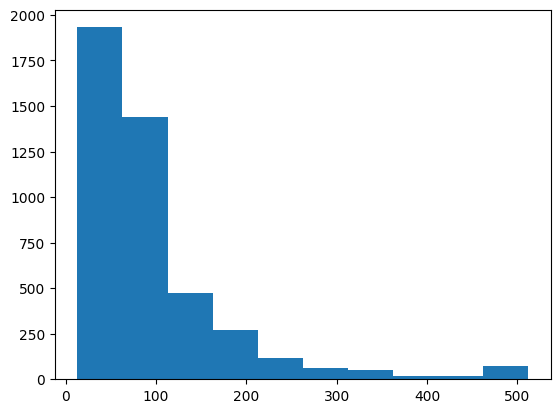

In [20]:
import matplotlib.pyplot as plt
plt.hist(token_lengths)

In [36]:
import numpy as np

indices = np.where(token_lengths == np.max(token_lengths))

In [37]:
indices

(array([  59,  128,  166,  188,  213,  337,  356,  471,  546,  595,  646,
         947,  958, 1057, 1069, 1092, 1140, 1261, 1281, 1313, 1318, 1383,
        1659, 1734, 1860, 1900, 2007, 2059, 2068, 2174, 2222, 2233, 2332,
        2512, 2576, 2874, 2943, 2950, 2979, 3042, 3281, 3291, 3639, 3715,
        3724, 3766, 3775, 3882, 3908, 3998, 4016, 4047, 4131, 4143, 4439]),)

### Histogram of non-zero token lengths (inset: character lengths in html data) per coarse label

In [35]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Initialize a dictionary to store token/char lengths for each category
category_token_lengths = {i: [] for i in labels.names}
category_char_lengths = {i: [] for i in labels.names}
cols = ['html_title', 'meta_description', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6']

# Iterate over the dataset and calculate non-zero token lengths for each category
for entry in tokenized_train_dataset:
    category = entry["coarse_label"]
    token_lengths = len([x for x in entry["input_ids"] if x != 0])
    category_token_lengths[category].append(token_lengths)

for entry in tokenized_test_dataset:
    category = entry["coarse_label"]
    token_lengths = len([x for x in entry["input_ids"] if x != 0])
    category_token_lengths[category].append(token_lengths)

# Iterate over the dataset and calculate char lengths for each category
for entry in dataset["train"]:
    char_lengths = 0
    category = entry["coarse_label"]
    for col in cols:
        if entry[col] != None:
            char_lengths += len(entry[col])
    category_char_lengths[category].append(char_lengths)

for entry in dataset["test"]:
    char_lengths = 0
    category = entry["coarse_label"]
    for col in cols:
        if entry[col] != None:
            char_lengths += len(entry[col])
    category_char_lengths[category].append(char_lengths)

/var/folders/m6/mfn6z53x3fd1tz624fvkd6y00000gn/T/ipykernel_27588/3730991914.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


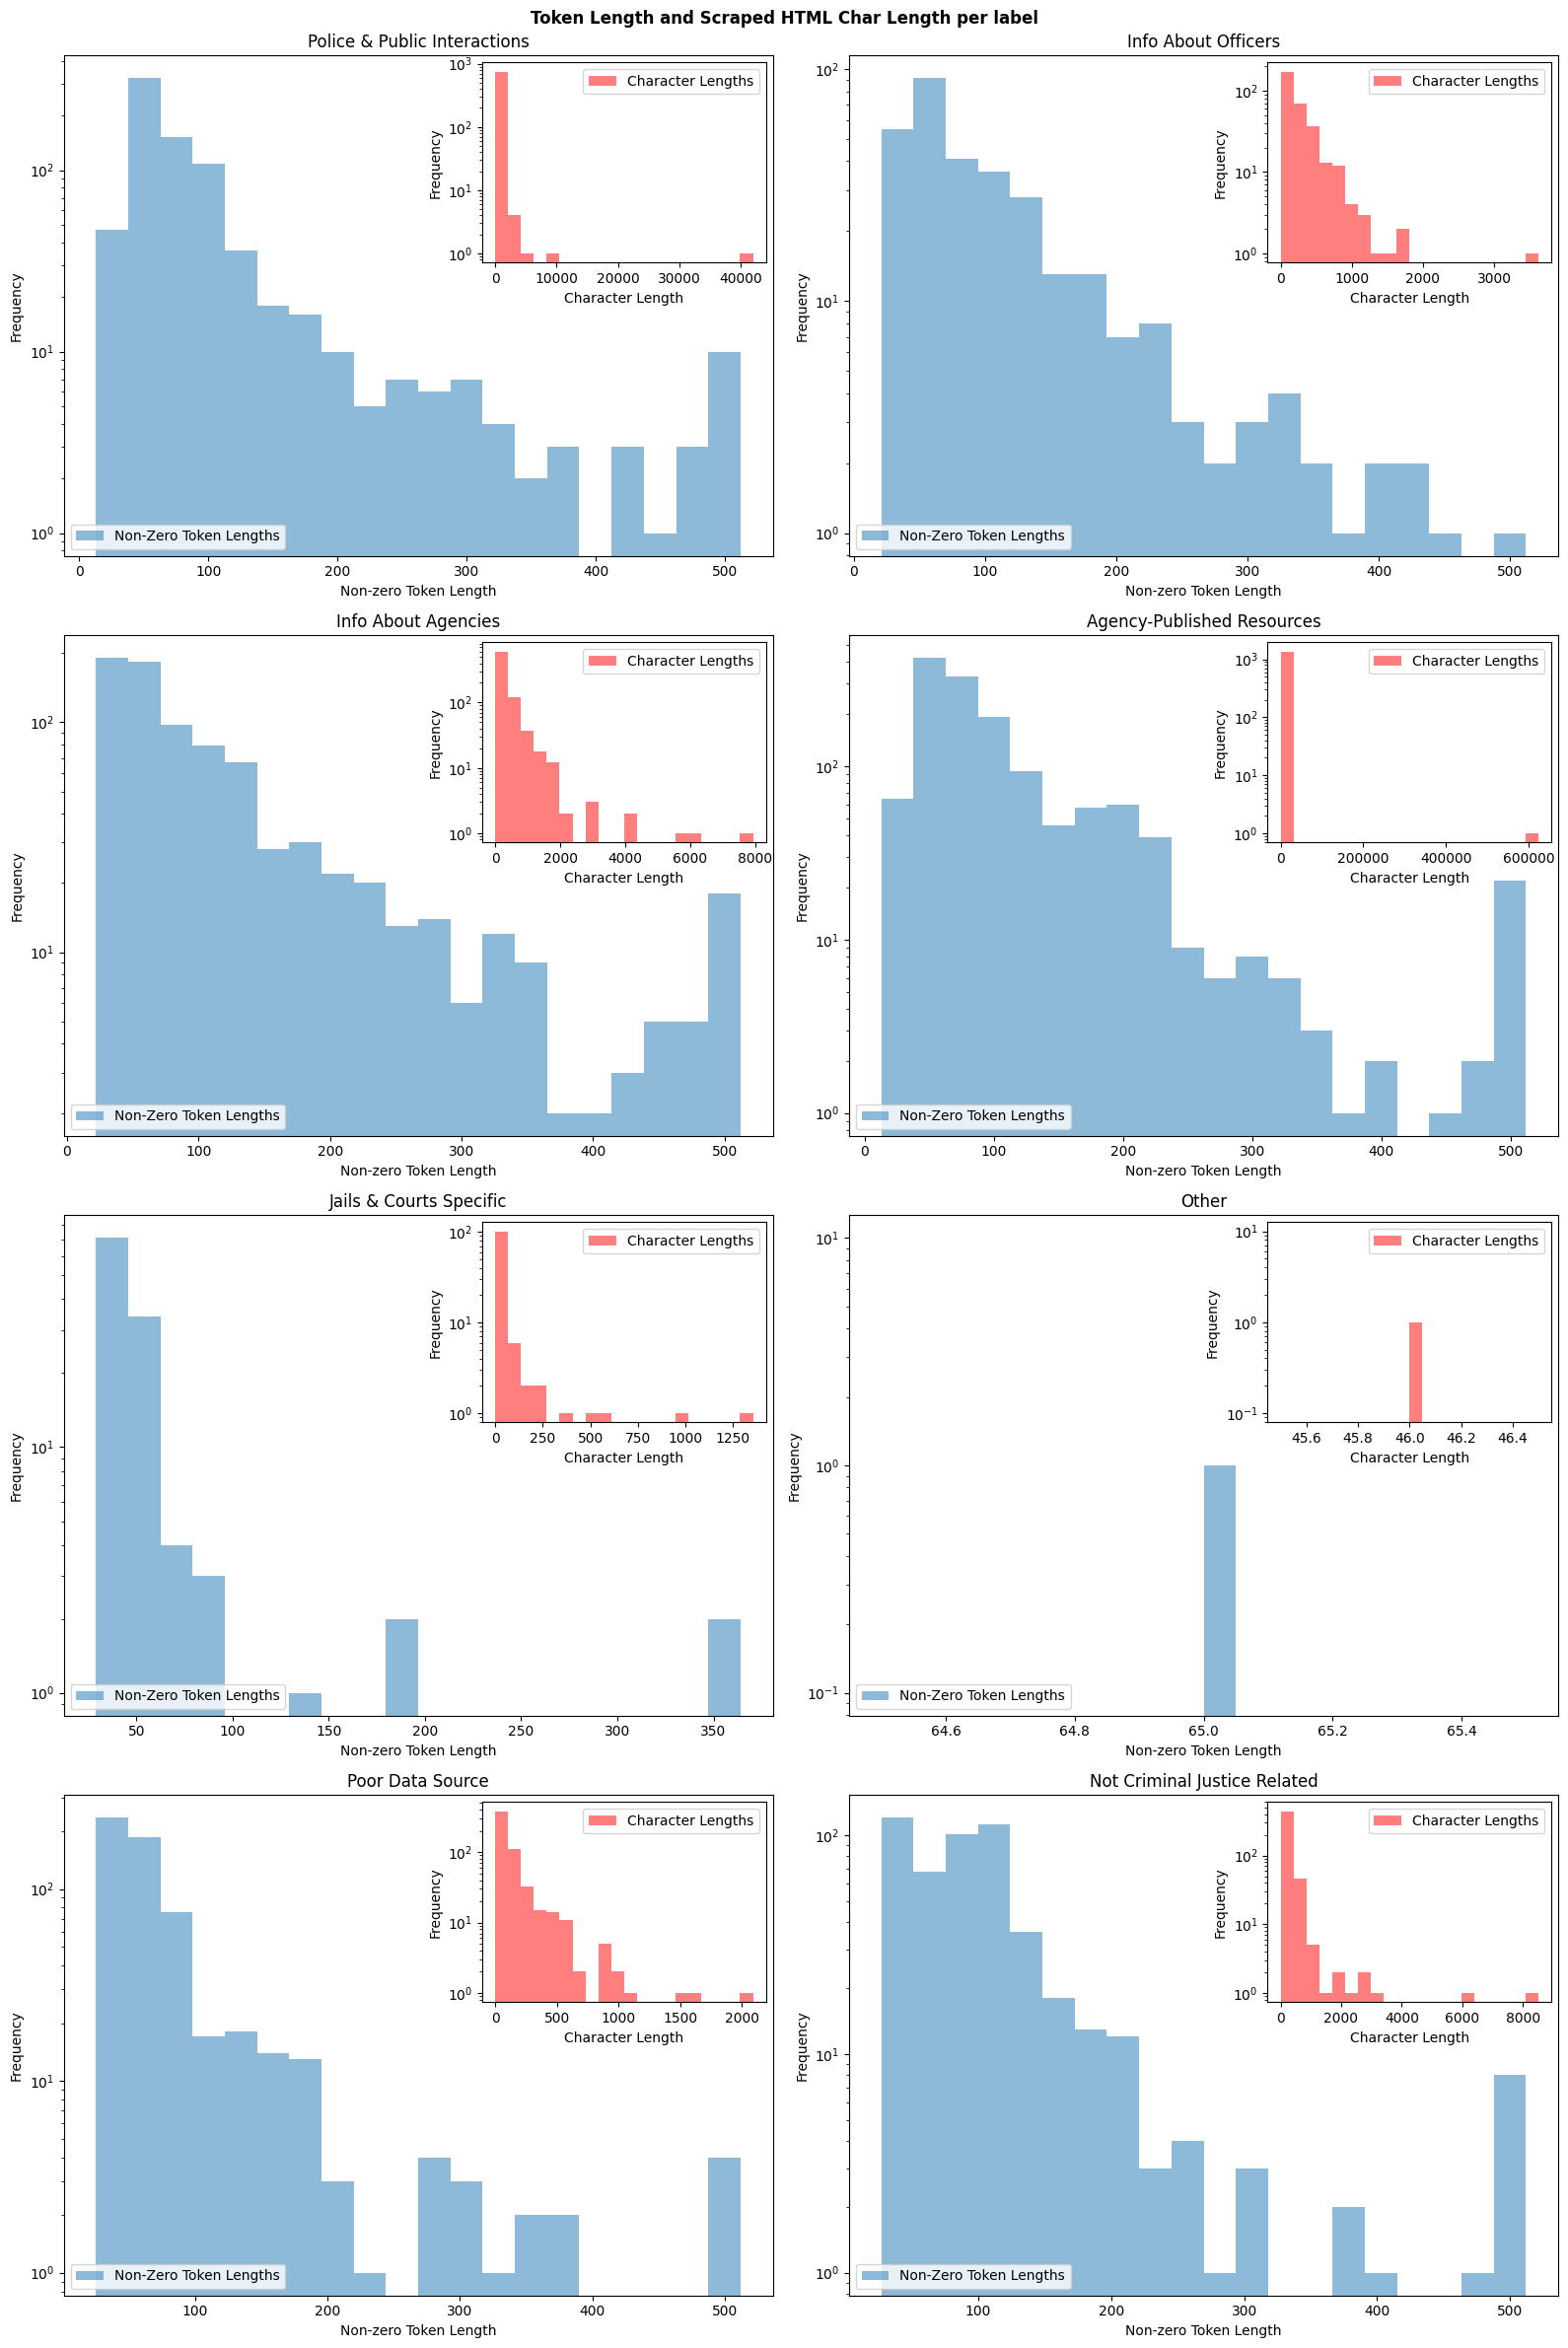

In [67]:
# Plot histograms for each category as subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 24))
axs = axs.flatten()

for i, (category, token_lengths) in enumerate(category_token_lengths.items()):
    ax = axs[i]
    ax.hist(token_lengths, bins=20, alpha=0.5, log=True, label='Non-Zero Token Lengths')
    ax.set_title(f"{category}")
    ax.set_xlabel("Non-zero Token Length")
    ax.set_ylabel("Frequency")
    ax.legend(loc='lower left')

for i, (category, char_lengths) in enumerate(category_char_lengths.items()):
     # Create inset axes for char lengths histogram
    inset_ax = inset_axes(axs[i], width="40%", height="40%", loc='upper right')
    inset_ax.hist(category_char_lengths[category], bins=20, color='red', alpha=0.5, log=True, label='Character Lengths')
    inset_ax.set_xlabel("Character Length")
    inset_ax.set_ylabel("Frequency")
    inset_ax.legend(loc='best')

plt.suptitle("Token Length and Scraped HTML Char Length per label", y=0.99, fontweight='bold')
plt.tight_layout()
plt.savefig("tokens+char_length-hist.png", dpi=300)
plt.show()

In [5]:
dataset["train"][0]

{'id': 2942,
 'url': 'https://www.gptc.edu/compliance-notices/open-records-requests/',
 'label': 'List of Data Sources',
 'coarse_label': 'Info About Agencies',
 'http_response': 200,
 'html_title': 'Open Records Requests – Georgia Piedmont Technical College',
 'meta_description': None,
 'h1': '[]',
 'h2': '[]',
 'h3': '["Compliance Notices"]',
 'h4': '["Programs of Study", "Registration"]',
 'h5': '[]',
 'h6': '[]'}